### Literatura

1. SEETHA, J.; RAJA, S. Selvakumar. Brain tumor classification using convolutional neural networks. Biomedical & Pharmacology Journal, 2018, 11.3: 1457.
2. AGARWAL, AMIT KUMAR, et al. Brain tumor classification using CNN. Advances and Applications in Mathematical Sciences, 2021, 20.3: 397-407.

### 1. Uvoz skupa podataka

In [ ]:
from glob import glob
from tabulate import tabulate

### 1.1 Struktura skupa podataka

In [6]:
directories = glob("../data/brain_tumor_dataset/*")
dataset_structure = [[x, len(glob(x + '/*'))] for x in directories]

print(tabulate([[x, len(glob(x + '/*'))] for x in directories], headers=['Direktorij', 'Broj slika'], tablefmt="grid"))
print(f'\nUkupan broj slika: {sum([len(glob(x + "/*")) for x in directories])}')

+----------------------------------------+--------------+
| Direktorij                             |   Broj slika |
+========================================+==============+
| ../data/brain_tumor_dataset\glioma     |         1621 |
+----------------------------------------+--------------+
| ../data/brain_tumor_dataset\healthy    |         2000 |
+----------------------------------------+--------------+
| ../data/brain_tumor_dataset\meningioma |         1645 |
+----------------------------------------+--------------+
| ../data/brain_tumor_dataset\pituitary  |         1757 |
+----------------------------------------+--------------+

Ukupan broj slika: 7023


### 1.2 Odabir uzorka

Odabrano je po 400 slika iz svake klase.

In [8]:
import numpy as np

In [11]:
np.random.seed(9)

glioma_sample = np.random.choice(glob(directories[0] + '/*.jpg'), 400, replace=False)
healthy_sample = np.random.choice(glob(directories[1] + '/*.jpg'), 400, replace=False)
meningioma_sample = np.random.choice(glob(directories[2] + '/*.jpg'), 400, replace=False)
pituitary_sample = np.random.choice(glob(directories[3] + '/*.jpg'), 400, replace=False)

In [12]:
all_paths = np.concatenate([
    glioma_sample,
    healthy_sample,
    meningioma_sample,
    pituitary_sample,
])
# 0=glioma, 1=healthy, 2=meningioma, 3=pituitary (primjer)
labels = np.array(
    [0] * 400 +
    [1] * 400 +
    [2] * 400 +
    [3] * 400
)

### 2. Podjela skupa podataka na skupove za treniranje, validaciju i testiranje

In [14]:

from sklearn.model_selection import train_test_split


X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(
    all_paths, labels, test_size=0.3, random_state=9, stratify=labels
)

X_val_paths, X_test_paths, y_val, y_test = train_test_split(
    X_temp_paths, y_temp, test_size=0.5, random_state=9, stratify=y_temp
)

print(f"Trening skup (70%): {len(X_train_paths)} slika") # 1120
print(f"Validacija skup (15%): {len(X_val_paths)} slika") # 240
print(f"Test skup (15%): {len(X_test_paths)} slika") # 240

Trening skup (70%): 1120 slika
Validacija skup (15%): 240 slika
Test skup (15%): 240 slika


### 3. Generator podataka

In [15]:
import cv2
import tensorflow as tf

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size=(224, 224), num_classes=5, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_paths = [self.image_paths[k] for k in indices]
        batch_labels = [self.labels[k] for k in indices]

        X = np.empty((self.batch_size, *self.target_size, 3), dtype=np.float32)

        for i, path in enumerate(batch_paths):

            img_cv2 = cv2.imread(path)

            if img_cv2 is None:
                print(f"Upozorenje: OpenCV nije uspio učitati sliku na lokalnom disku: {path}")
                continue

            # Konverzija iz BGR (OpenCV standard) u RGB (Keras/TensorFlow standard)
            img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

            img_resized = cv2.resize(img_rgb, self.target_size)

            img_array = img_resized.astype('float32') / 255.0

            X[i,] = img_array

        # One-hot encoding
        y = tf.keras.utils.to_categorical(batch_labels, num_classes=self.num_classes)

        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

c:\Users\nikol\Desktop\brain-tumor-classification\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


### 4. Instanciranje generatora za svaki skup

In [16]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

train_generator = CustomDataGenerator(X_train_paths, y_train, BATCH_SIZE, TARGET_SIZE, shuffle=True)
validation_generator = CustomDataGenerator(X_val_paths, y_val, BATCH_SIZE, TARGET_SIZE, shuffle=False)
test_generator = CustomDataGenerator(X_test_paths, y_test, BATCH_SIZE, TARGET_SIZE, shuffle=False)

### 5. Definiranje modela

In [17]:
import tensorflow as tf

NUM_CLASSES = 5

base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False, # Ne uključujemo originalne klasifikacijske slojeve
    input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,821 (105.14 MB)

 Trainable params: 12,848,133 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 6. Treniranje modela

In [18]:
NUM_EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator
)

c:\Users\nikol\Desktop\brain-tumor-classification\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.6205 - loss: 0.9271 - val_accuracy: 0.7902 - val_loss: 0.5191
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.8125 - loss: 0.4902 - val_accuracy: 0.8170 - val_loss: 0.4868
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.8562 - loss: 0.3787 - val_accuracy: 0.8482 - val_loss: 0.3858
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.9018 - loss: 0.2872 - val_accuracy: 0.8705 - val_loss: 0.3533
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.9036 - loss: 0.2644 - val_accuracy: 0.8884 - val_loss: 0.3164
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.9348 - loss: 0.1913 - val_accuracy: 0.8527 - val_loss: 0.3538
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.9375 - loss: 0.1870 - val_accuracy: 0.8884 - val_loss: 0.3052
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.9500 - loss: 0.1510 - val_accuracy: 0.8973 - v

### 7. Evaluacija modela

c:\Users\nikol\Desktop\brain-tumor-classification\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9018 - loss: 0.3007
Testna točnost: 90.18%
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step

--- Classification Report ---
              precision    recall  f1-score   support

      glioma       0.98      0.82      0.89        55
     healthy       0.96      0.94      0.95        54
  meningioma       0.79      0.88      0.83        60
   pituitary       0.91      0.96      0.94        55

    accuracy                           0.90       224
   macro avg       0.91      0.90      0.90       224
weighted avg       0.91      0.90      0.90       224



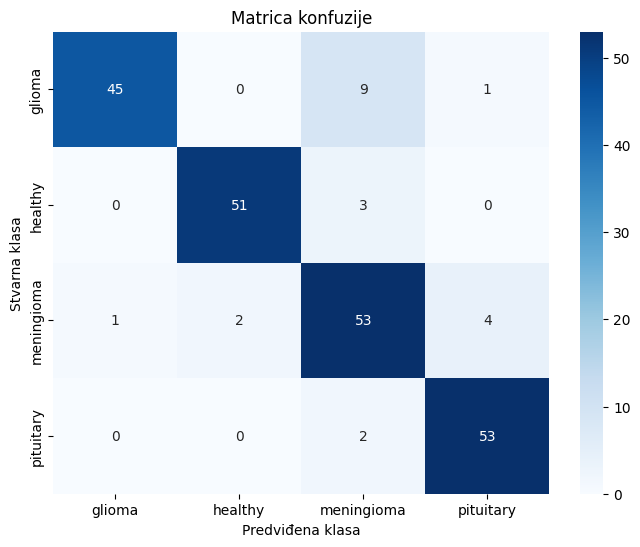

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

loss, accuracy = model.evaluate(test_generator)
print(f"Testna točnost: {accuracy*100:.2f}%")

y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

y_true_one_hot = []
for i in range(len(test_generator)):
    _, batch_y = test_generator[i]
    y_true_one_hot.extend(batch_y)
y_true = np.argmax(y_true_one_hot, axis=1)


target_names = ['glioma', 'healthy', 'meningioma', 'pituitary']
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred_classes, target_names=target_names))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matrica konfuzije')
plt.ylabel('Stvarna klasa')
plt.xlabel('Predviđena klasa')
plt.show()

In [20]:

import keras
keras.saving.save_model(model, '../models/brain_tumor_classification_model.keras')